# Numpy 1D-DFT

<font color="steelblue" size="4">

1. reference: http://dcwww.camd.dtu.dk/~askhl/files/python-dft-exercises.pdf
2. Goal: Write our own `Kohn-Sham(KS) DFT` code
    1. Target: a harmonic oscillator including:
        - electronic kinetic energy
        - electrostatic repulsion between electrons 
        - the local density approximation for electronic interactions, ignoring correlation
    1. `Hamitonian` for `Harmonic oscillator`:
        $$\begin{cases}
        \^{H} = -\frac{1}{2}\frac{d^2}{dx^2} + v(x) \\
        v(x) = v_{Ha}(x) + v_{LDA}(x) + x^2
        \end{cases}$$
3. What we have to do?
    1. Represent the `Hamiltonian for harmonic oscillator`
    2. Calculate the `KS wavefunction`, `the density`

</font>

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# 1. Free non-interacting electrons (For `Harmonic oscillator`)

<font color="red">

Note
----
1. Only contains `electronic kinetic energy`

</font >

In [2]:
num_grids = 201
xs_lst = np.linspace(-5, 5, num_grids)
ys_lst = np.sin(xs_lst)

## 1.1. First/Second order differentiation (FDM)

1. Approximately:
   $$ f^{'}(x) = \frac{f(x+dx) - f(x)}{dx} $$

2. Then: 
   $$ f^{''}(x) = \frac{f(x+dx) - 2f(x) + f(x-dx)}{dx^2} $$

3. We should represent `the second order differentiation` with `matrix`

In [3]:
# 1. calculate the space between grids
dx = np.diff(xs_lst).mean()

# 2. 将 Harmonic oscillator 的二阶导以矩阵形式表示
dia = -2 * np.ones(num_grids)
offdia = np.ones(num_grids - 1)
    # np.diag(offdia, 1)  : 首列加一列 (全为0)
    # np.diag(offdia, -1) : 首行加一行 (全为0)
derivative_x_2 = np.mat( np.diag(dia, 0) + np.diag(offdia, -1) + np.diag(offdia, 1) )
derivative_x_2 = derivative_x_2 / np.power(dx, 2)
operator_kinetic = - 1 / 2 * derivative_x_2

# 3. Avoid strage things at the edge of the grid
#d2grid[0, :] = 0
#d2grid[n_grid-1, :] = 0

print("The operator for kinetic energy of harmonic oscillator is represented by matrix:\n")
operator_kinetic

The operator for kinetic energy of harmonic oscillator is represented by matrix:



matrix([[ 400., -200.,    0., ...,    0.,    0.,    0.],
        [-200.,  400., -200., ...,    0.,    0.,    0.],
        [   0., -200.,  400., ...,    0.,    0.,    0.],
        ...,
        [   0.,    0.,    0., ...,  400., -200.,    0.],
        [   0.,    0.,    0., ..., -200.,  400., -200.],
        [   0.,    0.,    0., ...,    0., -200.,  400.]])

In [4]:
# eig_vals_lst: 本征值，按照升序排列，含重复
# eig_vecs_lst: 本征向量，eig_vecs_lst[i] 对应于 eig_vals_lst[i]
eig_vals_none_lst, eig_vecs_non_lst = np.linalg.eigh(operator_kinetic)

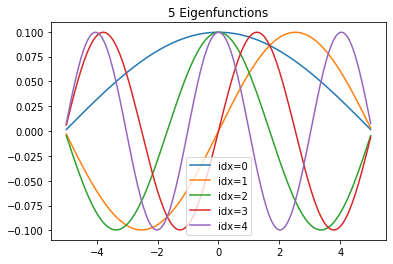

In [5]:
for idx in range(5):
    plt.plot(xs_lst, eig_vecs_non_lst[:, idx],
            label="idx={0}".format(idx))

plt.title('%d Eigenfunctions'%(5))
plt.legend()

## 2.1. Harmonic oscillator (`Adding potential energy`)
- Including the external potential $v_{external}=x^2$
$$ \^{H} = \^{T} = -\frac{1}{2}\frac{d^2}{dx^2} + x^2 $$

In [6]:
potentials_lst = np.power(xs_lst, 2)
potentials_matrix = np.diag(potentials_lst, 0)

In [7]:
potentials_matrix

array([[25.    ,  0.    ,  0.    , ...,  0.    ,  0.    ,  0.    ],
       [ 0.    , 24.5025,  0.    , ...,  0.    ,  0.    ,  0.    ],
       [ 0.    ,  0.    , 24.01  , ...,  0.    ,  0.    ,  0.    ],
       ...,
       [ 0.    ,  0.    ,  0.    , ..., 24.01  ,  0.    ,  0.    ],
       [ 0.    ,  0.    ,  0.    , ...,  0.    , 24.5025,  0.    ],
       [ 0.    ,  0.    ,  0.    , ...,  0.    ,  0.    , 25.    ]])

In [7]:
H = operator_kinetic + potentials_matrix

eig_vals_harm_lst, eig_vecs_harm_lst = np.linalg.eigh(H)

### 2.1.1. Plot up the `eigenvalues`

Text(0.5, 0, 'index $n$')

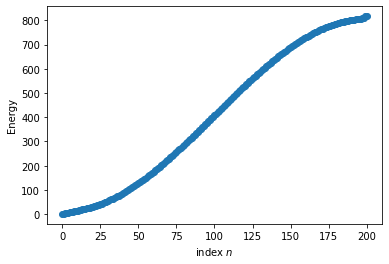

In [8]:
f, ax = plt.subplots()
ax.plot(eig_vals_harm_lst, 'o')
ax.set_ylabel('Energy')
ax.set_xlabel('index $n$')

### 2.1.2. plot some `eigenfunctions`

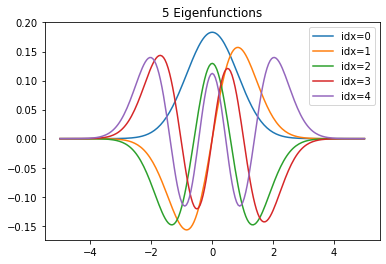

In [9]:
for idx in range(5):
    plt.plot(xs_lst, eig_vecs_harm_lst[:, idx],
            label="idx={0}".format(idx))

plt.title('%d Eigenfunctions'%(5))
plt.legend()

## 2.2. Well potential
- Hamiltonian:
$$ \^{H} = -\frac{1}{2}\frac{d^2}{dx^2} + V_{well}(x) $$

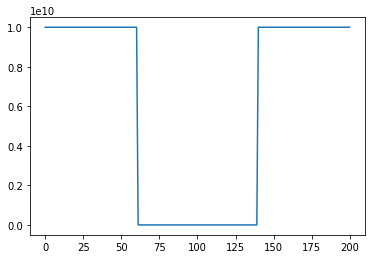

In [10]:
potentials_well_lst = np.full_like(xs_lst, 1e10)
potentials_well_lst[np.logical_and(xs_lst>-2, xs_lst<2)] = 0
plt.plot(potentials_well_lst)

In [11]:
eig_vals_well_lst, eig_vecs_well_lst = np.linalg.eigh(operator_kinetic + np.diag(potentials_well_lst))

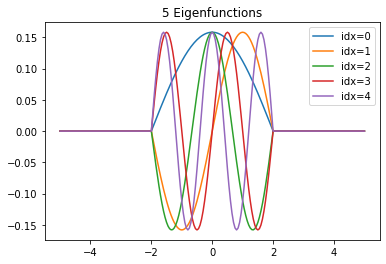

In [12]:
for idx in range(5):
    plt.plot(xs_lst, eig_vecs_well_lst[:, idx],
            label="idx={0}".format(idx))

plt.title('%d Eigenfunctions'%(5))
plt.legend(loc=1)

# 3. Density
1. We will want to include:
    - `Coulomb` interaction
    - `Hatree` interaction
    - `LDA exchange`
    - Both of which are `density functionals` (密度的泛函)
2. So we need to calculate the electron density
3. Each state should be normalized:
    $$ \int{|\psi|^2dx} = 1 $$
4. Let $f_n$ be occupation numbers, the density $n(x)$ can be written as follows:
    $$ n(x) = \sum_{n}{f_n|\psi(x)|^2} $$

<font color="red">

Note
----
1. Each state fits up to two electrons: 
    - one with `spin up`
    - one with `spin down`.
2. In DFT, we calculate the `ground state`.（`电子填充由能量低到高进行`）
3. 注意行、向量的转换/转置

</font>

In [13]:
### Part I. 积分
def get_integral(xs_lst, ys_lst, axis=0):
    dx = np.diff(xs_lst).mean()
    return np.sum(ys_lst * dx, axis=axis)

print(get_integral(
            xs_lst=xs_lst,
            ys_lst=np.power(eig_vecs_non_lst, 2),
            axis=0
))

[[0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05
  0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05
  0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05
  0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05
  0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05
  0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05
  0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05
  0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05
  0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05
  0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05
  0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05
  0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05
  0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05
  0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.

In [14]:
# 计算 density
def get_density(num_electrons, xs_lst, eig_vecs_lst):
    # 1. normalization
    I = get_integral(xs_lst=xs_lst,
                    ys_lst=np.power(eig_vecs_lst, 2),
                    axis=0)

    normed_eig_vecs_lst = eig_vecs_lst / np.sqrt(I)


    # 2. occupation number
    nums_electrons_lst = [2 for _ in range(num_electrons // 2)] 
    if (num_electrons % 2):
        nums_electrons_lst.append(1)
    
    # 3. calculate density
    densitys_lst = np.zeros_like(eig_vecs_lst[:, 0])    # 列向量
    for ne, psi in zip(nums_electrons_lst, normed_eig_vecs_lst.T):  # 
        # After this step, densitys_lst.shape = (201, 1)
        densitys_lst += ne * np.power(psi.T, 2)
    
    # After this step, densitys_lst = (201, )
    # Note: 必须先转换为 `np.array` 再使用 `ravel()` 方法
    densitys_lst = np.array(densitys_lst).ravel()
    
    return densitys_lst

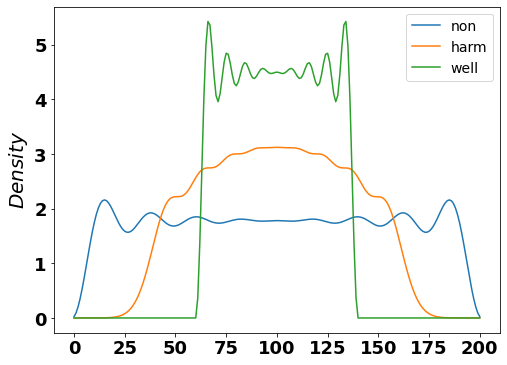

In [15]:
num_electrons = 17
plt.figure(figsize=(8, 6))
plt.plot( get_density(num_electrons,
                     xs_lst,
                     eig_vecs_non_lst), label="non")
plt.plot( get_density(num_electrons,
                     xs_lst,
                     eig_vecs_harm_lst), label="harm")
plt.plot( get_density(num_electrons,
                     xs_lst,
                     eig_vecs_well_lst), label="well")
## 3.1. retouch xlabel/ylabel

plt.ylabel("$Density$",
            fontsize="20",
            fontweight="bold")

## 3.2. retouch xticks/yticks
plt.xticks(fontsize="18",
            fontweight="bold")
plt.yticks(fontsize="18",
            fontweight="bold")

## 3.3. retouch legend
plt.rcParams.update({"font.size": 14})
plt.legend(loc=1)

plt.show()

# 4. Exchange Energy

<font color="steelblue" size="4">

1. Consider the `exchange functional` in the `LDA (Local Density Approximation)`:
    - Ignoring the corelation for simplicity.
$$ E^{LDA}_X[n] = -\frac{3}{4} (\frac{3}{\pi})^{\frac{1}{3}} \int{n^{\frac{4}{3}}dx} $$

2. The `potential` is given by `the derivative of the exchange energy` with respect to the density: 
$$ v_X^{LDA}[n] = \frac{\partial E_X^{LDA}}{\partial n} = - \left(\frac{3}{\pi}\right)^{1/3} n^{1/3}$$

</font>

In [16]:
def get_exchange(xs_lst, densitys_lst):
    energys_lst = -3/4 * np.power((3/np.pi), 1/3) * \
                    get_integral(xs_lst=xs_lst,
                                ys_lst=densitys_lst,
                                axis=0)
    potential_lst = -np.power(3/np.pi, 1/3) * \
                    np.power(densitys_lst, 1/3)
    
    return energys_lst, potentials_lst

# 5. Coulomb Potential

<font color="steelblue" size="4">

1. `Electrostatic energy` (or called `Hatree energy`)
2. The expression of 3D-Hatree energy is not converged in 1D
3. Hence we use a `modified` as follows:
$$ E_{Ha} = \frac{1}{2} \iint{\frac{n(x)n(x^{'})}{\sqrt{(x-x^{'})^2+\varepsilon}}}dxdx^{'} $$
4. The `potential` is given by:
$$ v_{Ha} = \int{\frac{n(x^{'})}{\sqrt{(x-x^{'})^2+\varepsilon}}}dx^{'} $$
5. In a `matrix expression`:
$$\begin{aligned}
E_{Ha} = \frac{1}{2}\sum_{i,j}{\frac{n_i n_j dx^2}{\sqrt{(x_i-x_j)^2+\varepsilon}} } \\
v_{Ha, i} = \sum_{i}\frac{n_j dx}{\sqrt{(x_i-x_j)^2 + \varepsilon}}
\end{aligned}$$

</font>

In [17]:
'''
python> lst = np.array([1,2,3])
python> lst_1 = lst[None, :]
python> lst_2 = lst[:, None]

python> lst
[[1 2 3]]

python> lst_2
[[1]
 [2]
 [3]]

python> lst_1 * lst_2
[[1 2 3]
 [2 4 6]
 [3 6 9]]
'''
def get_hatree(xs_lst, densitys_lst, eps=1e-1):
    dx = np.diff(xs_lst).mean()
    xs_lst = np.array(xs_lst)
    xs_lst = xs_lst.ravel()     # xs_lst.shape = (201,)
    
    # `np.sum()` 不给 `axis` 参数时，将整个矩阵求和
    energy = np.sum( densitys_lst[None, :] * densitys_lst[:, None] * \
                    np.power(dx, 2) / \
                    np.sqrt( np.power(xs_lst[None, :] - xs_lst[:, None], 2) + eps )
                    ) / 2
    # 此时 `np.sum(..., axis=1)`
    potentials_lst = np.sum( densitys_lst[None, :] * dx / \
                    np.sqrt( np.power(xs_lst[None, :] - xs_lst[:, None], 2) + eps ),
                    axis=1
                    )

    return energy, potentials_lst

In [18]:
get_hatree(xs_lst=xs_lst,
        densitys_lst=get_density(num_electrons=num_electrons,
                                xs_lst=xs_lst,
                                eig_vecs_lst=eig_vecs_non_lst)
        )

(95.05809715157166,
 array([ 6.10984996,  6.32771248,  6.55949313,  6.80380263,  7.05848005,
         7.3206722 ,  7.58698042,  7.85365182,  8.11679306,  8.37258724,
         8.61749828,  8.84844989,  9.06296958,  9.25929088,  9.43640993,
         9.59409569,  9.73285546,  9.85386038,  9.95883742, 10.04993617,
        10.12957995, 10.20031115, 10.26464053, 10.32490954, 10.38317339,
        10.44111086, 10.49996483, 10.56051526, 10.62308419, 10.6875703 ,
        10.75350865, 10.82014986, 10.88655205, 10.95167846, 11.01449343,
        11.07405038, 11.12956601, 11.18047653, 11.22647304, 11.26751497,
        11.30382209, 11.33584709, 11.36423194, 11.38975253, 11.41325621,
        11.43559754, 11.45757713, 11.47988798, 11.50307298, 11.52749611,
        11.55332876, 11.58055129, 11.60896892, 11.6382398 , 11.66791254,
        11.69746971, 11.72637366, 11.75411101, 11.78023248, 11.80438522,
        11.82633563, 11.84598145, 11.86335279, 11.87860279, 11.89198912,
        11.90384845, 11.9145663

# 6. Solve the KS equation: Self-consistency loop

<font color="steelblue" size="4">

1. Initialize the density (You can take an arbitrary constant)
2. Calculate the exchange and hartree potentials
3. Calculate the Hamiltion
4. Calculate the wavefunctions and eigen values
5. If not converged, calculate the density and back to 1.

</font>

In [19]:
def print_log(i, log):
    print(f"Step= {i:<5}:  Energy= {log['energy'][-1]:<10.4f}: Energy_DIFF= {log['energy_diff'][-1]:.10f}")

In [20]:
max_iters = 1000
energy_tolerance = 1e-5
log = {"energy":[float("inf")], "energy_diff":[float("inf")]}

In [21]:
densitys_lst = np.zeros(num_grids)

for idx in range(max_iters):
    ex_energy, ex_potential = get_exchange(xs_lst=xs_lst,
                                        densitys_lst=densitys_lst)
    ha_energy, ha_potential = get_hatree(xs_lst=xs_lst,
                                        densitys_lst=densitys_lst)

    # Hamiltonian
    H = operator_kinetic + np.diag(ex_potential+ha_potential, 0)
    
    eig_vals_lst, eig_vecs_lst = np.linalg.eigh(H)

    # log
    log["energy"].append(eig_vals_lst[0])
    energy_diff = log["energy"][-1] - log["energy"][-2]
    log["energy_diff"].append(energy_diff)
    print_log(idx, log)

    # convergence
    if abs(energy_diff) < energy_tolerance:
        break

    # update density
    densitys_lst = get_density(num_electrons=num_electrons,
                            xs_lst=xs_lst,
                            eig_vecs_lst=eig_vecs_lst)

Step= 0    :  Energy= 0.7070    : Energy_DIFF= -inf
Step= 1    :  Energy= 17.7868   : Energy_DIFF= 17.0798384381
Step= 2    :  Energy= 14.7636   : Energy_DIFF= -3.0231392071
Step= 3    :  Energy= 16.8223   : Energy_DIFF= 2.0586006473
Step= 4    :  Energy= 15.4325   : Energy_DIFF= -1.3897702688
Step= 5    :  Energy= 16.4132   : Energy_DIFF= 0.9807500553
Step= 6    :  Energy= 15.7200   : Energy_DIFF= -0.6932449660
Step= 7    :  Energy= 16.2208   : Energy_DIFF= 0.5007803009
Step= 8    :  Energy= 15.8590   : Energy_DIFF= -0.3617287671
Step= 9    :  Energy= 16.1230   : Energy_DIFF= 0.2639422216
Step= 10   :  Energy= 15.9306   : Energy_DIFF= -0.1923937882
Step= 11   :  Energy= 16.0715   : Energy_DIFF= 0.1408940394
Step= 12   :  Energy= 15.9684   : Energy_DIFF= -0.1030730744
Step= 13   :  Energy= 16.0440   : Energy_DIFF= 0.0755688931
Step= 14   :  Energy= 15.9886   : Energy_DIFF= -0.0553623683
Step= 15   :  Energy= 16.0292   : Energy_DIFF= 0.0406014550
Step= 16   :  Energy= 15.9995   : Energy

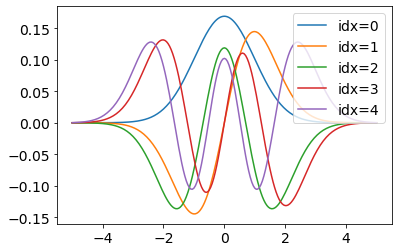

In [22]:
for i in range(5):
    plt.plot(xs_lst, eig_vecs_lst[:,i], label="idx={0}".format(i))
    plt.legend(loc=1)

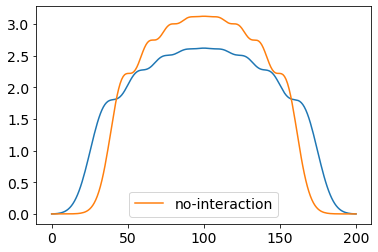

In [23]:
plt.plot(densitys_lst)
plt.plot(get_density(num_electrons=num_electrons,
                    xs_lst=xs_lst,
                    eig_vecs_lst=eig_vecs_harm_lst),
        label="no-interaction")
plt.legend(loc=0)